# Victoria Airbnb analysis

## Import libraries
Import the necessary libraries for analyis and visualization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from plotnine import *
import warnings
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor

%matplotlib inline
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (15,10)

## Data prepartion 
* Define class and function to correctly format and clean data. 

* Load data to objects for further analysis and modelling

In [2]:
# Define helper functions for eda and data cleansing

def clean_date(date_col):
    '''Clean date cols'''
    return date_col.astype(np.datetime64)

def clean_currency(curr_col):
    '''Clean currency formated columns'''
    return curr_col.replace('[\$,]','',regex=True).astype('float64')

def clean_bool(bool_col):
    '''Clean boolean col'''
    return bool_col.replace({'t':True,'f':False})

def find_col_contains(df,string):
    '''Find columns contains string in a dataframe, return a dataframe with those columns'''
    return df[df.columns[df.columns.str.contains(string)]]

def profile_data(df,unique_no = 5, first_n_char = 10):
    '''
    Profile a dataframe, showing column name, no of unique values, and its unique values
    with limited character for readability. 
    
    '''
    for col in df.columns:
        nuniques = df[col].nunique()
        unique_vals = [str(val)[:first_n_char] for val in df[col].unique()[:unique_no]]
        print(col," (",nuniques,'): ',unique_vals ,sep='')

def drop_columns(df,cols):
    '''Drop multiple columns at once'''
    for col in cols:
        df.drop(col,axis=1,inplace=True)

In [3]:
class airbnb_city_data:
    '''
    Create object to load, clean Kaggle AirBnB data.

    The datasets for this project can be downloaded here:
    http://insideairbnb.com/get-the-data.html

    Parameters:
    ------
    location: Pass in folder name location containing AirBnB data.
    data_dir: Optionally pass in directory to data folders
    '''
    def __init__(self, location = 'victoria', data_dir = '../data/'):
        self.location = location
        self.dir = data_dir
        self.listings = self.reviews = self.calendar = pd.DataFrame()


    def load_data(self):
        '''Load the data from file and store in the object'''
        files = ['listings','calendar','reviews']
        path = self.dir + self.location
        for file in files:
            df = pd.read_csv(path + '/' + file + '.csv')
            setattr(self,file,df)

    def clean_calendar(self):
        '''Clean calendar df'''
        self.calendar['location'] = self.location
        self.calendar.date = clean_date(self.calendar.date)
        self.calendar.price = clean_currency(self.calendar.price)
        self.calendar.available = clean_bool(self.calendar.available)

    def clean_reviews(self):
        '''Clean reviews df'''
        self.reviews['location'] = self.location
        self.reviews.date = clean_date(self.reviews.date)

    def clean_listings(self):
        '''Clean listings df'''
        self.listings['location'] = self.location
        
        #Clean boolean cols
        bool_cols = self.listings.columns[self.listings.isin(['t','f']).mean() > 0]
        for col in bool_cols:
            self.listings[col] = clean_bool(self.listings[col])
        #Clean currency cols
        curr_cols = (self.listings.iloc[self.listings.isna().sum(axis=1).idxmin()].
                     str.startswith('$').fillna(False)[lambda x: x].index)
        for col in curr_cols:
            self.listings[col] = clean_currency(self.listings[col])
        #Clean date cols
        for k,v in self.listings.iloc[self.listings.isna().sum(axis=1).idxmin()].items():
            if re.match('[0-9]{4}\-[0-9]{1,2}\-[0-9]{1,2}',str(v)) != None:
                self.listings[k] = clean_date(self.listings[k])
        #Remove outliers listing
        threshold = self.listings.price.quantile(0.99)
        self.listings.price = self.listings.price[lambda x: x<threshold]
        self.listings.dropna(subset=['price'],inplace=True)
        
        #Flatten ammenities column
        self.listings['amenities'] = (self.listings.amenities.replace('[{}"]','',regex=True).
                                      apply(lambda x: x.split(',')).pipe(pd.DataFrame))
        
        mlb = MultiLabelBinarizer()
        self.listings = self.listings.join(pd.DataFrame(mlb.fit_transform(self.listings.pop('amenities')),
                                              columns='amen_'+mlb.classes_,index = self.listings.index).
                                           astype('bool'))
        
        #Turn long text column to boolean (null or not null)
        long_text_cols = (self.listings.select_dtypes('object').
                          apply(lambda x: x.str.len().mean())[lambda x: x>30].index)
        long_text_df = self.listings.copy()[long_text_cols]
        drop_columns(self.listings, long_text_cols)
        long_text_df.columns = 'has_' + long_text_df.columns
        long_text_df = long_text_df.notnull()
        self.listings = self.listings.join(long_text_df)
        
        #Drop all NA cols
        #na_cols = self.listings.columns[self.listings.isna().sum() == self.listings.shape[0]]
        na_cols = self.listings.columns[self.listings.nunique() == 1]
        drop_columns(self.listings, na_cols)
        
        #Drop columns with more than 50% missing data
        missing_cols = (self.listings.isnull().sum()/self.listings.shape[0])[lambda x: x>.5].index
        drop_columns(self.listings,missing_cols)

        
    def init(self):
        '''Load, clean data, load them to objects for further analysis '''
        self.load_data()
        self.clean_calendar()
        self.clean_reviews()
        self.clean_listings()
        return self.listings, self.calendar, self.reviews

In [4]:
# Initialize object and load data
vic = airbnb_city_data()
listings, calendar, reviews = vic.init()

## Data exploration

In [5]:
# Show data
listings.head()

,id,host_id,host_name,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,...,has_notes,has_transit,has_access,has_interaction,has_house_rules,has_host_location,has_host_about,has_host_thumbnail_url,has_host_picture_url,has_jurisdiction_names
0,1591,1748,Jeff,2008-08-11,within a day,100%,False,8.0,8.0,True,...,True,True,True,True,True,True,True,True,True,True
1,12125,46544,Kelly-Ann,2009-10-17,within a few hours,100%,False,2.0,2.0,True,...,False,True,True,False,False,True,True,True,True,True
2,14560,57242,Lilly,2009-11-24,within an hour,100%,False,1.0,1.0,True,...,True,True,True,True,True,True,True,True,True,True
3,18101,69729,Ryan,2010-01-11,NaN,NaN,False,4.0,4.0,True,...,False,False,False,False,False,True,False,True,True,True
4,18103,69729,Ryan,2010-01-11,NaN,NaN,False,4.0,4.0,True,...,False,False,False,False,False,True,False,True,True,True


In [6]:
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,location
0,910427,2019-05-26,False,88.0,$88.00,2,29,victoria
1,2060849,2019-05-26,False,150.0,$150.00,7,1125,victoria
2,2060849,2019-05-27,False,150.0,$150.00,7,1125,victoria
3,2060849,2019-05-28,False,150.0,$150.00,7,1125,victoria
4,2060849,2019-05-29,False,150.0,$150.00,7,1125,victoria


In [7]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,location
0,12125,248623,2011-05-02,521712,Trevor,Accommodations were comfortable. We appreciate...,victoria
1,12125,4383815,2013-05-01,81092,Mark,Only met Kelly -Anne briefly but she came well...,victoria
2,12125,5647488,2013-07-09,1488420,Lauriane,Our stay in Kelly-Ann's place has been wonderf...,victoria
3,12125,6927326,2013-08-30,8349475,Lucie,Our trip to North Pender Island was so peacefu...,victoria
4,12125,9024688,2013-12-02,9604544,Leslie,I judge vacation rentals by kitchen knives. If...,victoria


In [8]:
# Get basic stats of listings df
listings.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
id,3618,NaN,NaN,NaN,NaN,NaN,1.95758e+07,9.77488e+06,1591,1.28544e+07,2.00741e+07,2.76049e+07,3.50693e+07
host_id,3618,NaN,NaN,NaN,NaN,NaN,7.24433e+07,7.01988e+07,1748,1.42372e+07,4.47275e+07,1.18111e+08,2.6408e+08
host_name,3617,1502,Elite Vacation Homes,43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_since,3617,1637,2015-05-04 00:00:00,45,2008-08-11 00:00:00,2019-05-25 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_response_time,3075,4,within an hour,2325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_response_rate,3075,37,100%,2685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_is_superhost,3617,2,False,2074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_listings_count,3617,NaN,NaN,NaN,NaN,NaN,8.02792,71.137,0,1,1,3,1668
host_total_listings_count,3617,NaN,NaN,NaN,NaN,NaN,8.02792,71.137,0,1,1,3,1668
host_has_profile_pic,3617,2,True,3613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
class plot_ggplot:
    def __init__(self,df,figure_size=(10,5)):
        self.df = df 
        self.figure_size = figure_size


    def group_by(self,x,y,agg_func = 'count',sort = True, date_freq = ''):
        if date_freq:
            grouper = pd.Grouper(key=x, freq = date_freq)
        else:
            grouper = x
        df_groupby = self.df.groupby(grouper)[y].agg(agg_func).dropna().reset_index()
        if sort:
            df_groupby.sort_values(y,ascending=False,inplace=True)
            sort_col = pd.api.types.CategoricalDtype(categories = df_groupby[x].values)
            df_groupby[x] = df_groupby[x].astype(str).astype(sort_col)
        return df_groupby

    def plot_barchart(self,x,y,agg_func='count',limit=None):
        df = self.group_by(x,y,agg_func)
        plot = (ggplot(df.iloc[:limit], aes(x,y)) + geom_bar(stat='identity') +
                theme(figure_size=self.figure_size,axis_text_x=element_text(angle=45)) +
                geom_text(aes(label = y),va='bottom',size =10,format_string='{:,.1f}')
               )
        print(plot)

    def plot_linechart(self,x,y,agg_func='count',date_freq = ''):
        df = self.group_by(x,y,agg_func,sort=False,date_freq = date_freq)
        plot = (ggplot(df,aes(x,y)) + geom_line() +
                theme(figure_size=self.figure_size,axis_text_x=element_text(angle=45))
        )
        print(plot)

    def plot_stacked_barchart(self,x,y,agg_func='count',freq=True):
        df = self.group_by(x,y,agg_func,sort=False)
        df['freq'] = df[y] / df[y].sum()

        format_string='{:,.1f}'
        if freq:
            y = 'freq*100'
            format_string='{:,.2f}%'

        plot = (ggplot(df,aes(1, y, fill=x)) + geom_bar(stat='identity') +
                theme(figure_size=(8,1)) + xlab('') + ylab(x) + coord_flip() +
                geom_text(aes(label=y),format_string=format_string)

                )
        print(plot)

## Question 1: What Victoria neighborhood has the most listings? 

In [10]:
# Count listing group by neighbourhood, calculate % of total
nbh = listings.pivot_table('id',['neighbourhood_cleansed','neighbourhood_group_cleansed'],
                           aggfunc=['count', lambda x: x.count()/listings.shape[0]])
nbh = nbh.droplevel(1,axis=1)
nbh.columns = ['Listing count','% of total']
nbh.sort_values('% of total',ascending=False,inplace=True)
nbh['% of total'] = nbh['% of total'].apply(lambda x: '{0:.1%}'.format(x))
nbh.index.names = ['Neighbourhood','Neighbourhood group']
nbh.head()

,,Listing count,% of total
Neighbourhood,Neighbourhood group,,
Saanich,Saanich,720,19.9%
Downtown,Victoria,480,13.3%
Salt Spring Island,Salt Spring Island,318,8.8%
Langford,Langford,219,6.1%
Southern Gulf Islands,Southern Gulf Islands,189,5.2%


## Question 2: What is the most popular neighborhood according to reviews?

In [11]:
# Calculate review count by neighborhood and their average rating
nbhrv = listings.pivot_table(['number_of_reviews','review_scores_value'],
                             ['neighbourhood_cleansed','neighbourhood_group_cleansed'],
                     aggfunc={'number_of_reviews':'sum','review_scores_value':'mean'})

nbhrv.columns = ['Review count','Average rating']
nbhrv.index.names = ['Neighbourhood','Neighbourhood group']
nbhrv.sort_values('Review count',ascending=False,inplace=True)
nbhrv.head()

,,Review count,Average rating
Neighbourhood,Neighbourhood group,,
Downtown,Victoria,32750,9.624719
Saanich,Saanich,19142,9.591803
Salt Spring Island,Salt Spring Island,13391,9.652778
Southern Gulf Islands,Southern Gulf Islands,7881,9.703488
James Bay,Victoria,7652,9.620438


In [12]:
# Average rating in Victoria
listings.review_scores_value.mean()

9.660807291666666

### Question 3: What is the best time of year to visit Victoria? 

In [13]:
# Group by year, calculating review count
reviews.groupby(pd.Grouper(key='date',freq='Y')).id.count()

date
2011-12-31       31
2012-12-31      213
2013-12-31      811
2014-12-31     2606
2015-12-31     7443
2016-12-31    17062
2017-12-31    33450
2018-12-31    56476
2019-12-31    20428
Freq: A-DEC, Name: id, dtype: int64

In [14]:
# Filter relevant years only
rev = reviews[reviews.date.dt.year.isin([2016,2017,2018])]
rev['month'] = rev.date.dt.month

In [15]:
rev.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,location,month
22,12125,90844772,2016-08-02,4900810,Randy,Mermaid's Rest Guesthouse and our host Kelly-A...,victoria,8
23,12125,96304620,2016-08-22,27968223,Amanda,"Kelly-Ann was a great host, and her home is be...",victoria,8
24,12125,99797245,2016-09-06,30121945,Spencer,Nicest Cabin Ever! We all want to move it with...,victoria,9
50,14560,63783342,2016-02-27,5751535,Leanne,Elise was a wonderful host and the condo was t...,victoria,2
51,14560,86724866,2016-07-17,14392938,Dana,This condo was absolutely wonderful. It was we...,victoria,7


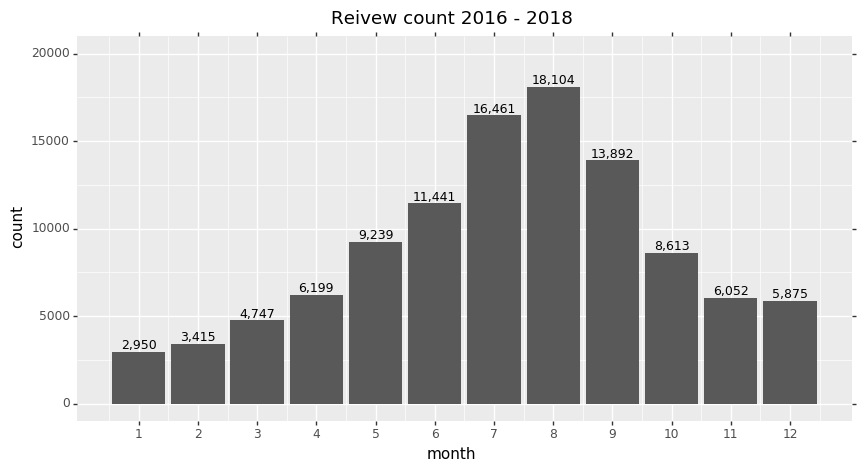

<ggplot: (-9223372036570403121)>

In [16]:
# Plot review count from 2016 to 2018
(ggplot(rev,aes('month')) + geom_bar(stat='count') + ylim((0,20000)) + 
 geom_text(aes(label='stat(count)'),stat='count', va='bottom', size =9, format_string= "{:,d}") +
 theme(figure_size=(10,5)) + scale_x_continuous(breaks=range(1,13)) + ggtitle('Reivew count 2016 - 2018')
) 

In [17]:
# % of review count by month
rev.month.value_counts(normalize=True) * 100

8     16.921524
7     15.385838
9     12.984634
6     10.693723
5      8.635548
10     8.050436
4      5.794108
11     5.656709
12     5.491270
3      4.436946
2      3.191947
1      2.757319
Name: month, dtype: float64

In [18]:
# % of reivew count of top 4 months
(rev.month.value_counts(normalize=True) * 100).iloc[:4].sum()

55.985718024451344

### Question 4: What amenities are the most common? 


In [19]:
# Show top 10 common aminities 
amenities = find_col_contains(listings,'amen').sum()
amenities.sort_values(ascending=False).reset_index().head(10).rename({0:'count'},axis=1)

,index,count
0,amen_Wifi,3500
1,amen_Heating,3488
2,amen_Essentials,3467
3,amen_Smoke detector,3367
4,amen_Kitchen,3208
5,amen_Hangers,3175
6,amen_Free parking on premises,2888
7,amen_Shampoo,2885
8,amen_Hair dryer,2840
9,amen_TV,2809


### Question 5: Can we predict price of a new listing? 

In [20]:
# Choose relevant columns that a new listing may have to prevent data leakage 
object_cols = ['neighbourhood_cleansed','property_type',
       'room_type', 'bed_type', 'cancellation_policy']
float_cols = ['latitude',
       'longitude', 'bathrooms', 'bedrooms', 'beds', 'price' ]
bool_cols = ['instant_bookable',
       'has_neighborhood_overview', 'has_notes', 'has_transit', 'has_access',
       'has_interaction', 'has_house_rules', 'has_host_location',
       'has_host_about', 'has_host_thumbnail_url', 'has_host_picture_url',
       'has_jurisdiction_names']
int_cols = ['accommodates', 'guests_included', 'minimum_nights']

In [21]:
# Create training data df
training_data = listings[object_cols+float_cols+bool_cols + int_cols]

In [22]:
# Onehotencode categorical data, drop na values
training_data = training_data.join(pd.get_dummies(training_data[object_cols]))
training_data.drop(object_cols,axis=1,inplace=True)
training_data.dropna(axis=0,inplace=True)

In [23]:
# Define X, y
y = pd.DataFrame(training_data.pop('price'))
X = training_data

In [24]:
# Scale numerical columns
sc = StandardScaler()
numeric_cols = X.select_dtypes(['int64','float64']).columns

sc_transformed_cols = pd.DataFrame(sc.fit_transform(X[numeric_cols]), columns=numeric_cols, index = X.index)
X.drop(numeric_cols,axis=1,inplace=True)
X = X.merge(sc_transformed_cols,left_index= True, right_index = True, how='left')

In [25]:
# Split train test df
X_train,X_test,y_train,y_test =train_test_split(X,y)

In [26]:
# Define models
models = ['SGDRegressor', 'RandomForestRegressor', 'AdaBoostRegressor', 
          'BaggingRegressor', 'GradientBoostingRegressor']

In [27]:
# Fit, train, evaluate models 
scores = {}
for model in models: 
    globals()[model] = eval(model + '()')
    globals()[model].fit(X_train,y_train)
    score = globals()[model].score(X_test,y_test)
    scores[model] = score
scores

{'SGDRegressor': 0.566848857164965,
 'RandomForestRegressor': 0.5376716523822443,
 'AdaBoostRegressor': 0.3844012586595668,
 'BaggingRegressor': 0.5649596902108649,
 'GradientBoostingRegressor': 0.5895686011629369}

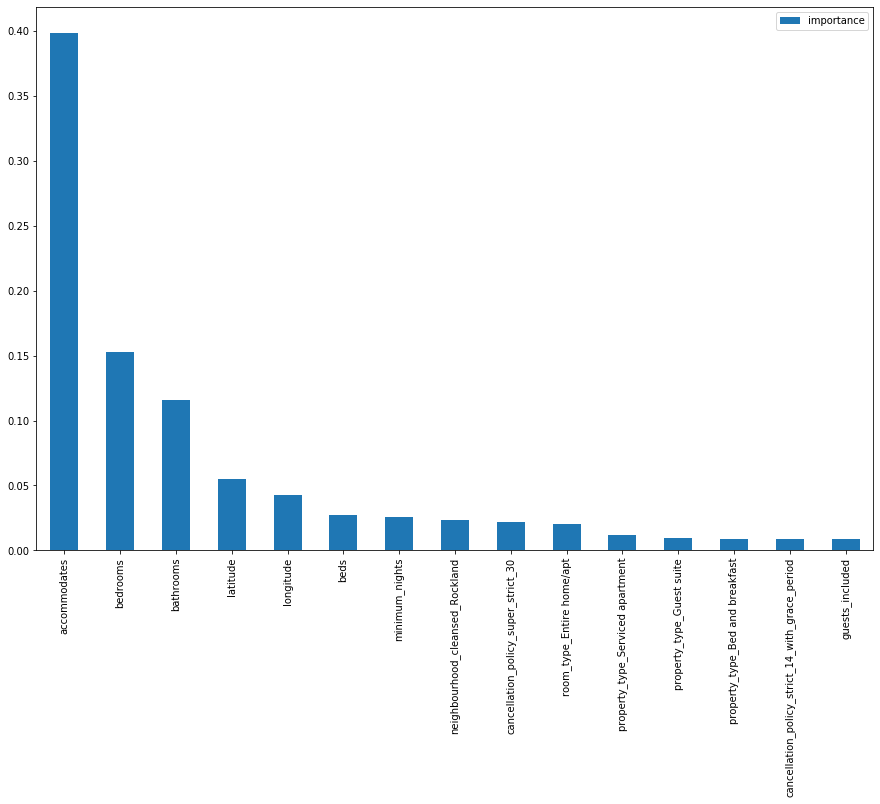

In [30]:
# Visualize feature importance for the best model
feature_importances = pd.DataFrame(GradientBoostingRegressor.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

feature_importances.sort_values('importance',ascending=False).head(15).plot(kind='bar',figsize=(15,10))